# TSIA202a - Third Practice Session

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.


# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p}
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma_2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


LIsten to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


# 1. Yule-Walker equations
QUESTION 1

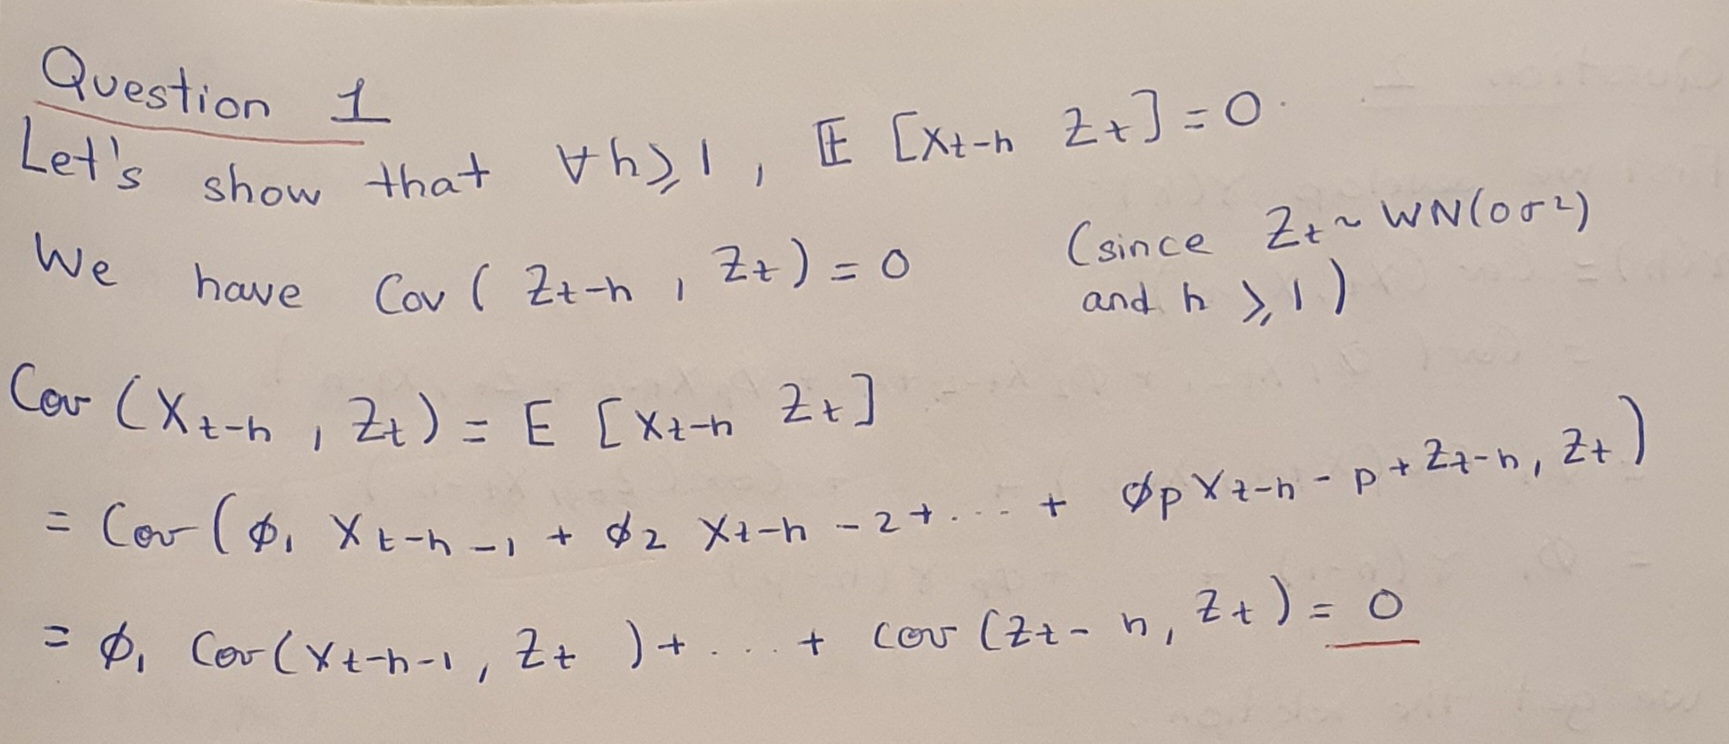

In [123]:
from IPython.display import Image
image_path =r'C:\Users\manel\OneDrive\Documents\2A\tsia\tp3_monroux_wafra\q1.jpg' 
Image(filename=image_path , width=300, height=200)

QUESTION 2

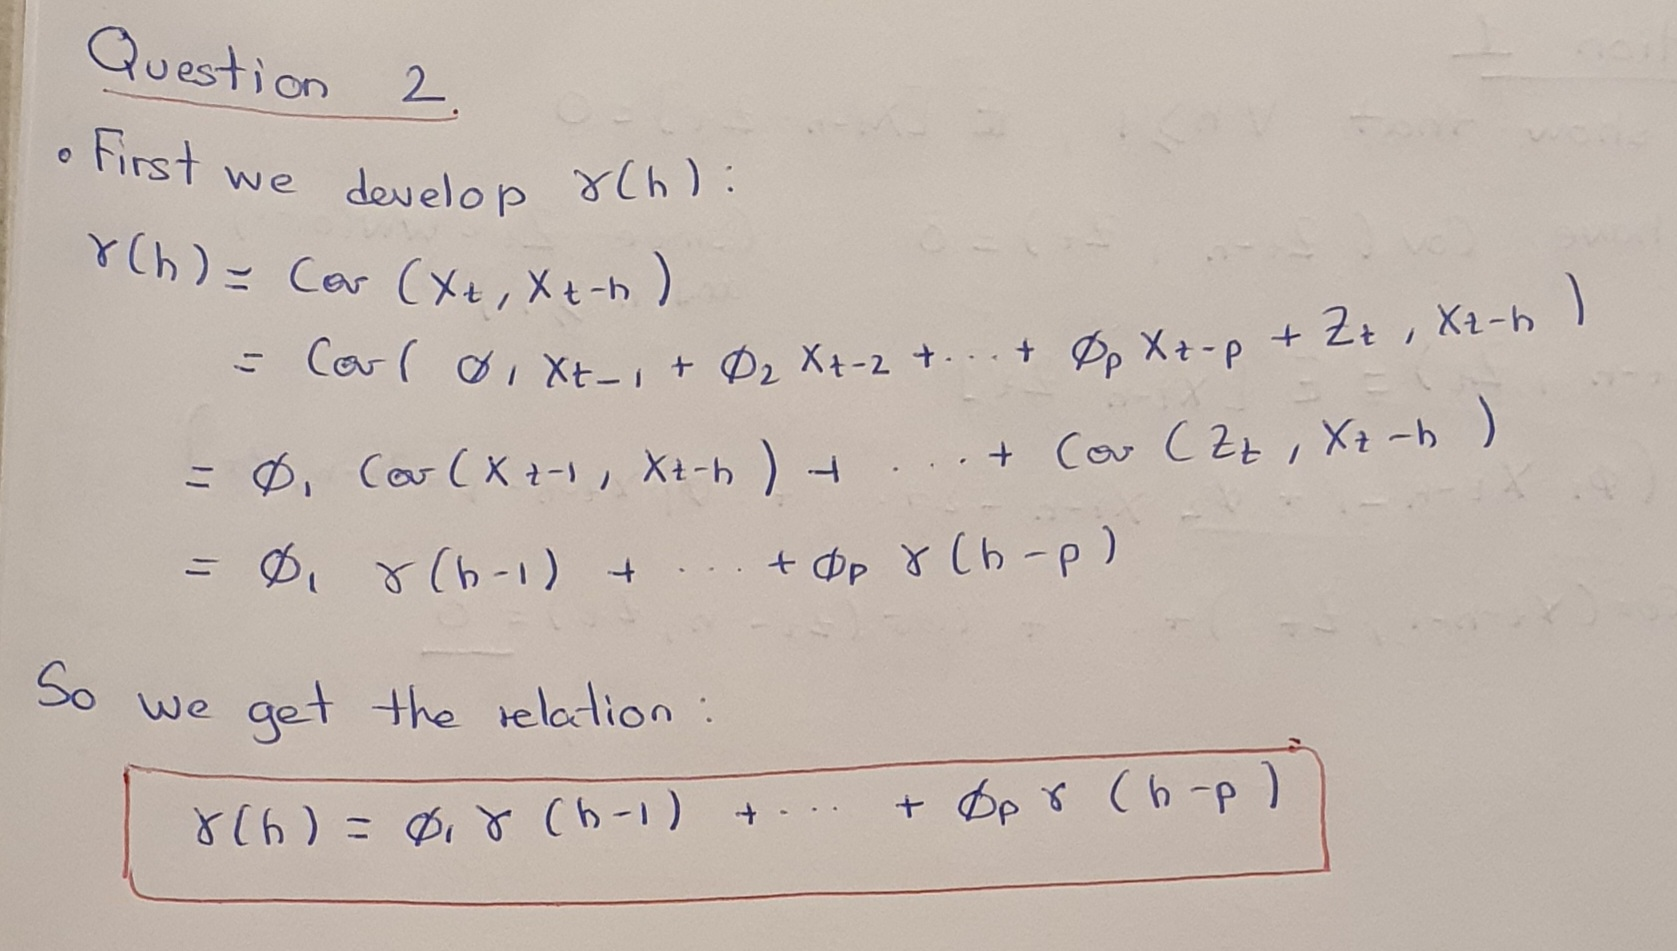

In [124]:
from IPython.display import Image
image_path =r'C:\Users\manel\OneDrive\Documents\2A\tsia\tp3_monroux_wafra\q2.jpg' 
Image(filename=image_path , width=300, height=200)

QUESTION 3

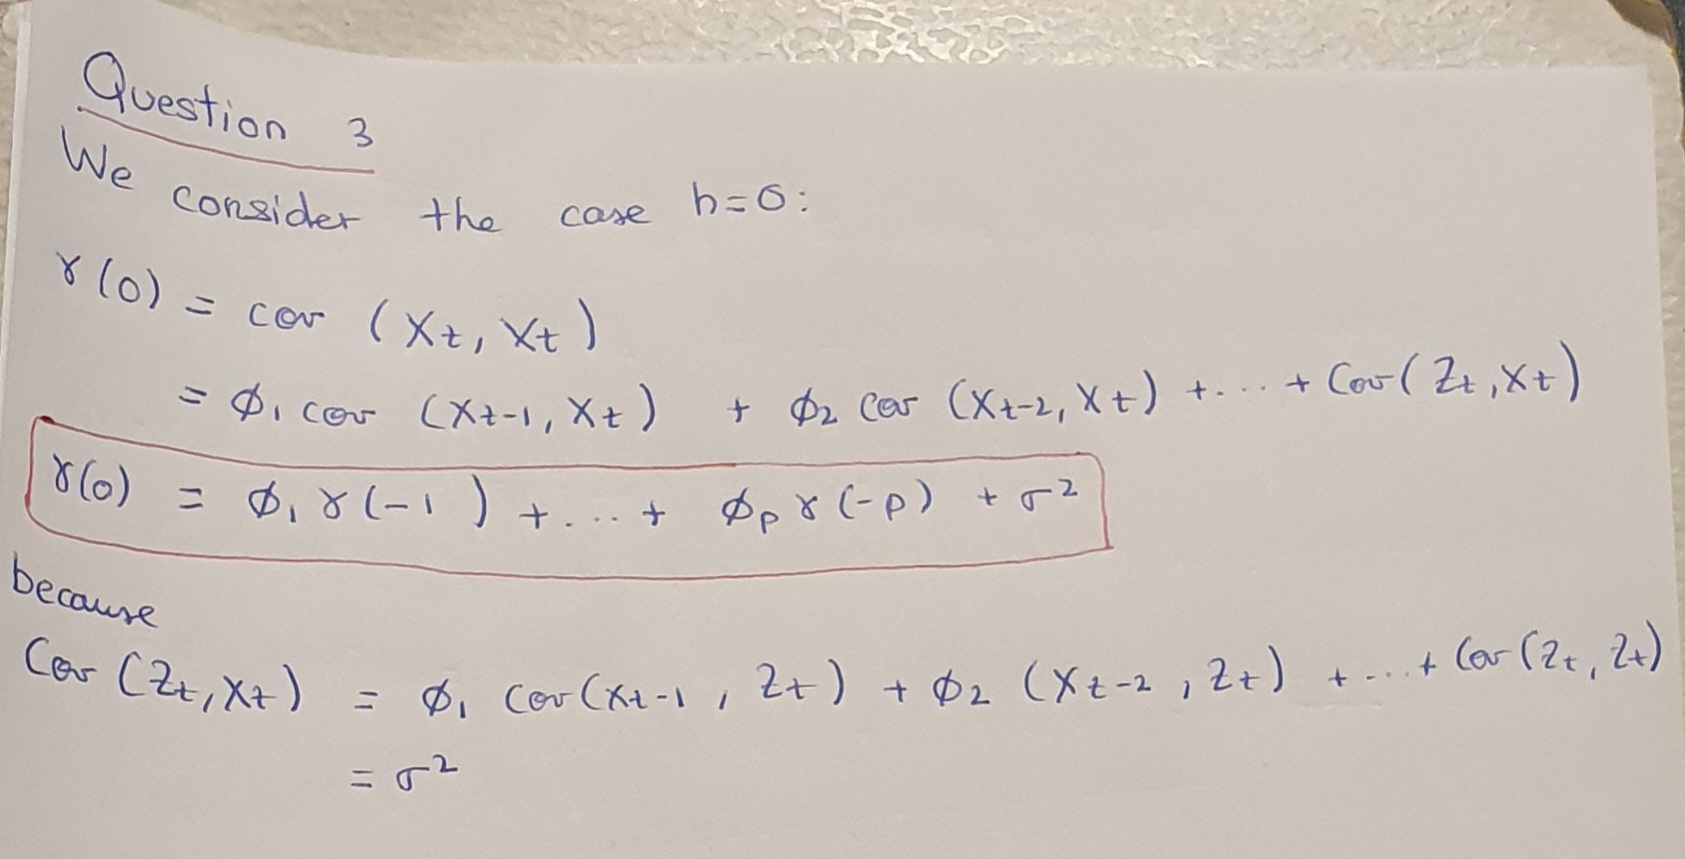

In [125]:
from IPython.display import Image
image_path =r'C:\Users\manel\OneDrive\Documents\2A\tsia\tp3_monroux_wafra\q3.jpg' 
Image(filename=image_path , width=300, height=200)

QUESTION 4

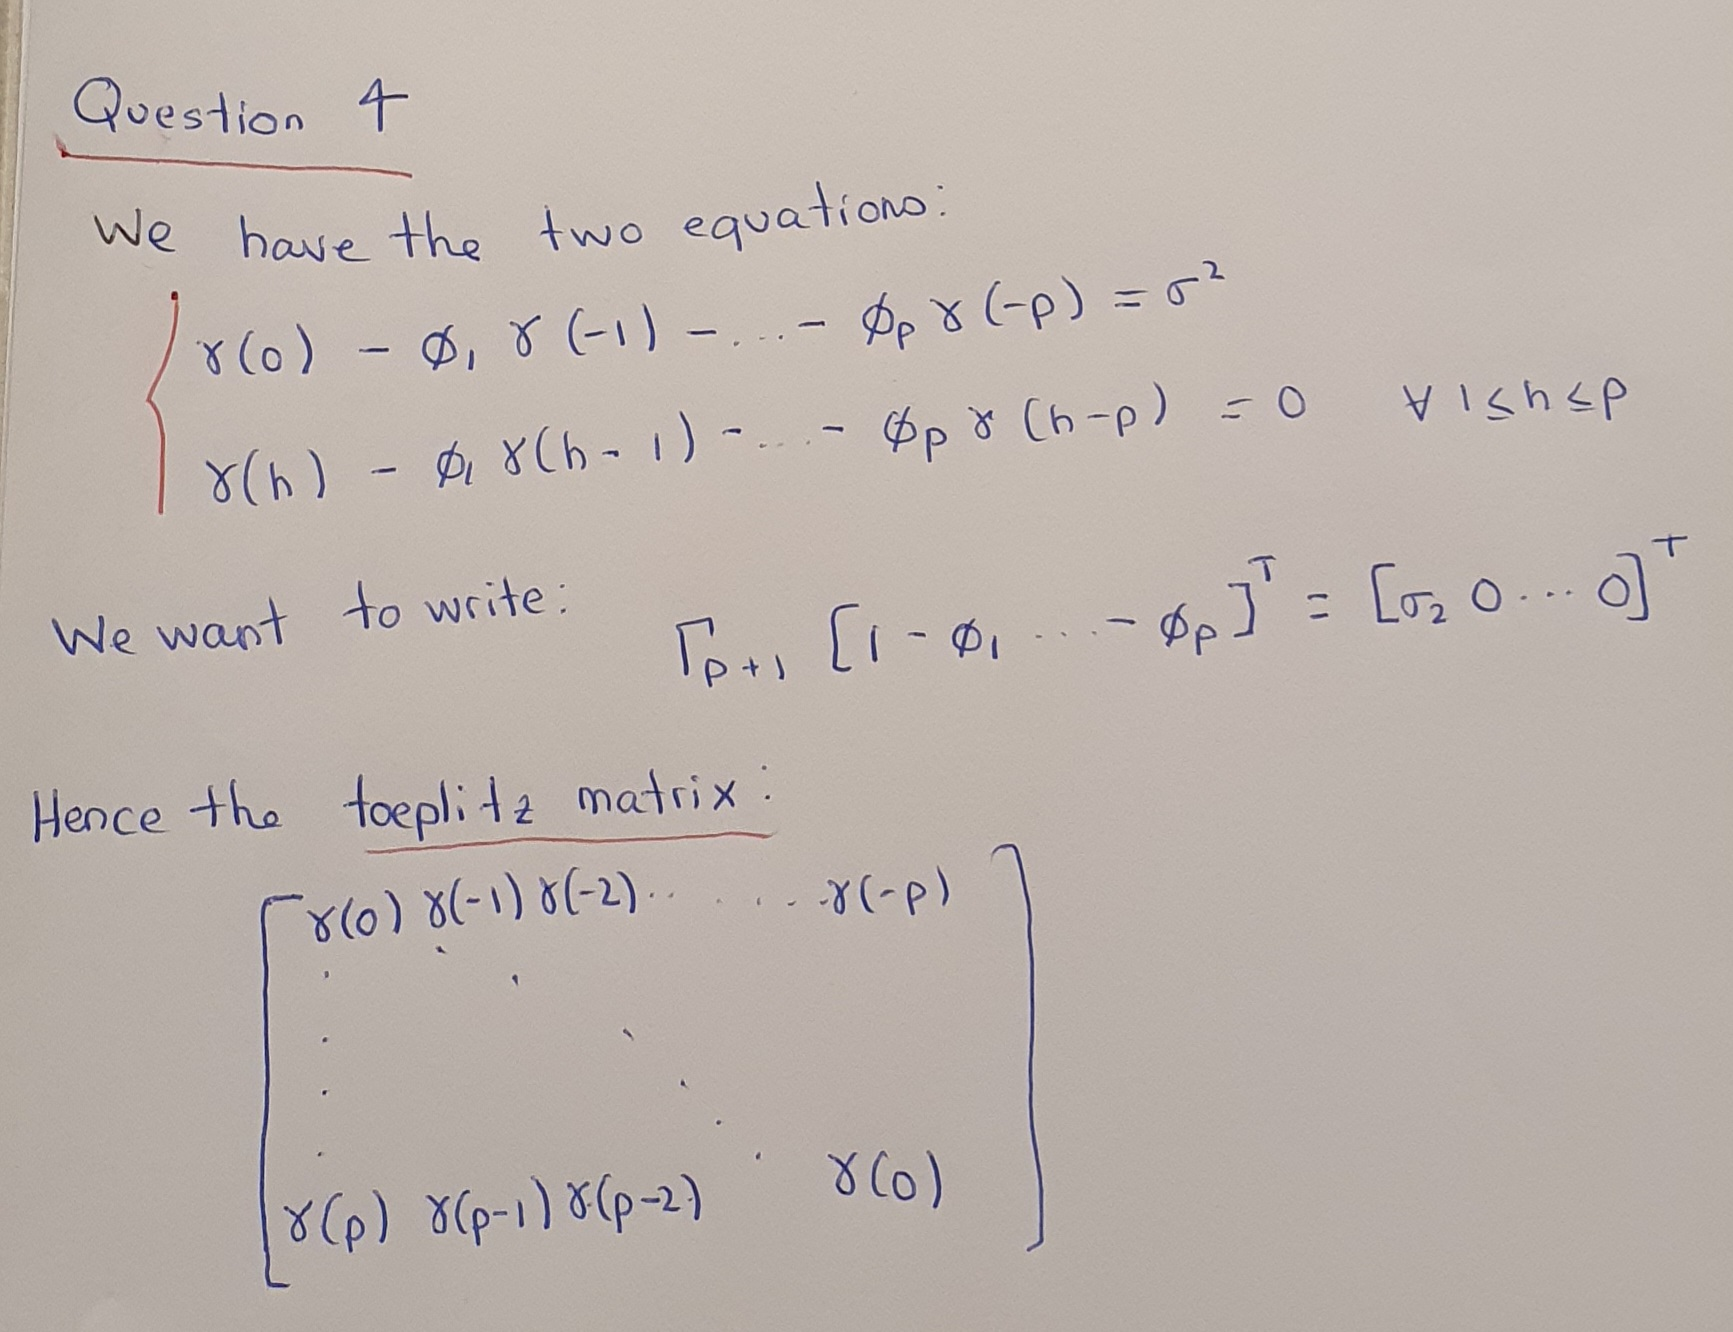

In [126]:
from IPython.display import Image
image_path =r'C:\Users\manel\OneDrive\Documents\2A\tsia\tp3_monroux_wafra\q4.jpg' #'photo1.jpg'
Image(filename=image_path , width=300, height=200)


# 2. Evaluation on synthetic data
QUESTION 1

Let's generate an array that contains 1000 samples of the AR(4) process

In [127]:
## imports

import librosa
import soundfile as sf
import scipy
import numpy as np
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

In [128]:
from scipy import signal as sig    

def AR(p,n,noiseSTD=1): 
    nrc = int(p/2) #% number of complex roots

    # Set the module of the poles in the (0.5 0.999) interval
    rho = .5+0.499*np.sqrt(np.random.random_sample(nrc)) 
    theta = 2*np.pi*np.random.random_sample(nrc)
    zk = rho *np.exp(1.j *theta);
    
    # Compute transient lenght
    zmax = zk[np.abs(zk)==np.max(np.abs(zk))]
    rhomax = np.abs(zmax)
    tau = -1./np.log(rhomax) 
    transient = int(5*tau)    #  we allow for some room
    
    zk = np.concatenate((zk, np.conjugate(zk)))
    if np.remainder(p,2): # we need to add one real positive root in the interval (0,1)
        realRoot = np.random.random_sample()
        zk =  np.concatenate(([realRoot], zk))
                                      
    coeff = np.poly(zk) # coefficients of polynomial p(z) = prod_k( z-z_k);
    coeff = np.real(coeff) # remove possible imag residuals due to limited precision
    
    phi = -coeff[1:]; # coefficients of the recurrence equation
                
    # White noise generation. Lenght = n+transient
    noise = noiseSTD*np.random.randn(n+transient)

    # final generation of the AR signal 
    X =  sig.lfilter([1], coeff, noise)
    
    # Removing the transient
    X=X[transient:]

    return X, phi



C:\Users\manel\AppData\Local\Temp\ipykernel_24808\4012813031.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transient = int(5*tau)    #  we allow for some room


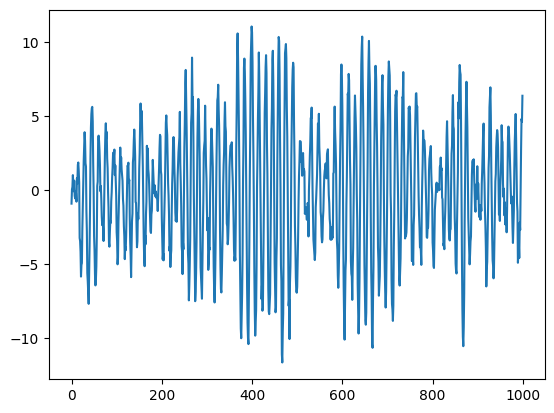

In [129]:
p=4
n=1000
X,phi = AR(p,n)
plt.plot(X)
plt.show()


QUESTION 2
* We use the correlation estimator to approach the coefficients of the Toeplitz matrix :

In [130]:
from scipy import linalg as la
def esti(X=None):

    Xc = X - np.mean(X)    
    m = 2 * X.size - 1
    I = np.abs(np.fft.fft(Xc,m)) ** 2 /  X.size
    gamma = np.real(np.fft.ifft(I))    
    gamma = gamma[0:X.size]
    return gamma

gamma= esti(X)
Gamma_hat = la.toeplitz( gamma[:p+1])

print(Gamma_hat)

[[19.44154997 17.41311816 12.88427563  6.26420314 -1.35968355]
 [17.41311816 19.44154997 17.41311816 12.88427563  6.26420314]
 [12.88427563 17.41311816 19.44154997 17.41311816 12.88427563]
 [ 6.26420314 12.88427563 17.41311816 19.44154997 17.41311816]
 [-1.35968355  6.26420314 12.88427563 17.41311816 19.44154997]]


QUESTIONS 3 AND 4

Estimated Coefficients: [ 1.         -0.8462777  -0.27747804  0.07884154  0.4558878 ]
True Coefficients: [ 1.         -0.79019295 -0.30399112  0.01456395  0.51522752]
Relative error: 7.62%


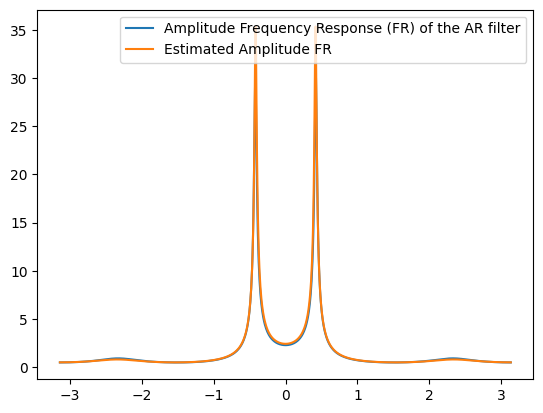

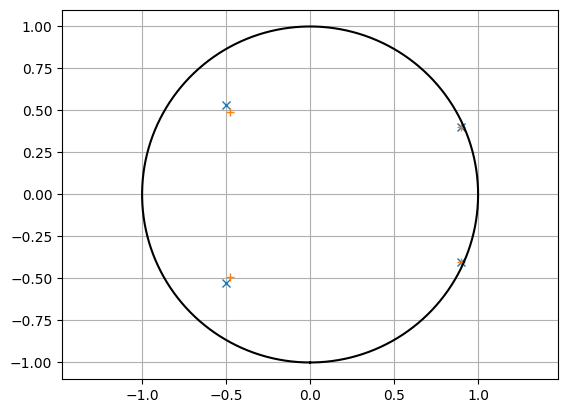

In [131]:

from numpy.linalg import inv, norm

# Define parameters
p = 4
v1 = np.zeros(p + 1)
v1[0] = 1

# Calculate coefficients
c = np.dot(inv(Gamma_hat), v1)
sigma2_est = 1 / c[0]
estimated_coefficients = c * sigma2_est
estimated_coefficients[0] = 1

# True coefficients
true_coefficients = np.concatenate(([1], -phi))

# Print results
print("Estimated Coefficients:", estimated_coefficients)
print("True Coefficients:", true_coefficients)

# Calculate error
error = true_coefficients - estimated_coefficients
relative_error = norm(error) / norm(true_coefficients)
print(f'Relative error: {relative_error:.2%}')

# Plot amplitude frequency response
plt.figure()
n_points = int(2**np.ceil(np.log2(X.size)))
nu = np.linspace(-0.5, 0.5 - 1/n_points, n_points)
omega = 2 * np.pi * nu

w1, H1 = sig.freqz([1], true_coefficients, omega)
w2, H2 = sig.freqz([1], estimated_coefficients, omega)

plt.plot(w1, np.abs(H1))
plt.plot(w2, np.abs(H2))
plt.legend(['Amplitude Frequency Response (FR) of the AR filter', 'Estimated Amplitude FR'])

# Plot poles
plt.figure()
plt.axis('equal')
plt.grid()

zk_true = np.roots(true_coefficients)
plt.plot(np.real(zk_true), np.imag(zk_true), 'x')

zk_estimated = np.roots(estimated_coefficients)
plt.plot(np.real(zk_estimated), np.imag(zk_estimated), '+')

t = np.linspace(-np.pi, np.pi, 1000)
plt.plot(np.sin(t), np.cos(t), 'black')

plt.show()


# 3. Speech modeling

In [132]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 12 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

In [133]:
## synthesis

# load audio
x = librosa.load('audio.wav', sr=sampling_rate)[0]

# pre-emphasis filtering
x = scipy.signal.lfilter([1, -0.98], [1], x)

# handy variables
n_frame = math.floor(len(x) / (sampling_rate * frame_duration * (1 - overlap_ratio))) - 1 # discard last frame
frame_length = int(sampling_rate * frame_duration)
min_period = math.floor(sampling_rate / f_max)
max_period = math.ceil(sampling_rate / f_min)
synthesis = np.zeros(len(x))
log_dict = defaultdict(list)

# loop over frames
for frame_index in tqdm(range(n_frame)):

    # extract frame
    start = int(frame_index * sampling_rate * frame_duration * (1 - overlap_ratio))
    end = start + frame_length
    frame = x[start:end]

    # detect pitch
    auto_covariance = np.fft.irfft(np.abs(np.fft.rfft(frame - np.mean(frame), (2*frame_length-1)))**2 / frame_length)[:frame_length]
    pitch, max_value = auto_covariance[min_period:].argmax() + min_period, auto_covariance[min_period:].max() / auto_covariance[0]
    if (pitch > max_period) or (max_value * frame_length / (frame_length - pitch) < pitch_detection_threshold): # detect silent frame 
        pitch = 0
    
    # estimate AR(p) coefficients
    gamma = gamma
    v = np.array([1 if k==0 else 0 for k in range(p+1)])
    coefficient = estimated_coefficients
    sigma = sigma2_est
    coefficient = true_coefficients

    # re-synthetise frame
    if pitch == 0:
        noise =  noise = np.random.normal(0, np.sqrt(sigma), frame_length+p)
        frame_r = scipy.signal.lfilter([1], coefficient, noise)
    else:
        dirac_comb = np.zeros(frame_length+p)
        dirac_comb[::pitch] = 1
        frame_r = scipy.signal.lfilter([1], coefficient, dirac_comb)
    frame_r = frame_r[p:]
    normalization_factor = np.sqrt(sigma / np.var(frame_r))
    frame_r = normalization_factor * frame_r[:frame_length]

    # overlap-add
    synthesis[start:end] += frame_r * np.hanning(frame_length)

    # compute power spectral density (for logging purposes)
    original_psd =np.abs(np.fft.rfft(frame))**2
    synthesis_psd = np.abs(np.fft.rfft(frame_r))**2

    # log
    log_dict["frame"].append(frame)
    log_dict["pitch"].append(pitch)
    log_dict["sigma"].append(sigma)
    log_dict["coefficient"].append(coefficient)
    log_dict["frame_r"].append(frame_r)
    log_dict["original_psd"].append(original_psd)
    log_dict["synthesis_psd"].append(synthesis_psd)

# de-emphasis filtering
synthesis = scipy.signal.lfilter([1], [1, -0.98], synthesis)

# log
sf.write('synthesis.wav', synthesis, sampling_rate)
log_dict["synthesis"].append(synthesis)
log_dict = {k: np.array(v) for k, v in log_dict.items()}

  0%|          | 0/279 [00:00<?, ?it/s]

100%|██████████| 279/279 [00:00<00:00, 2328.83it/s]


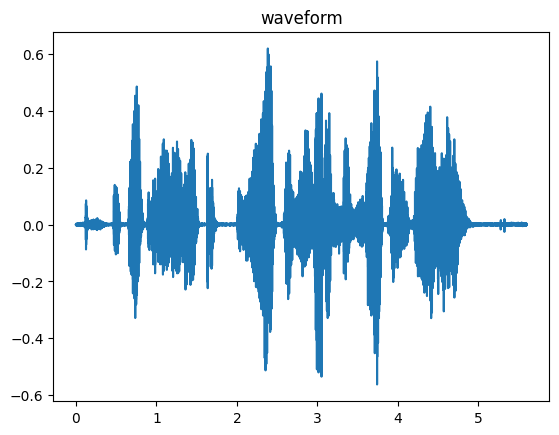

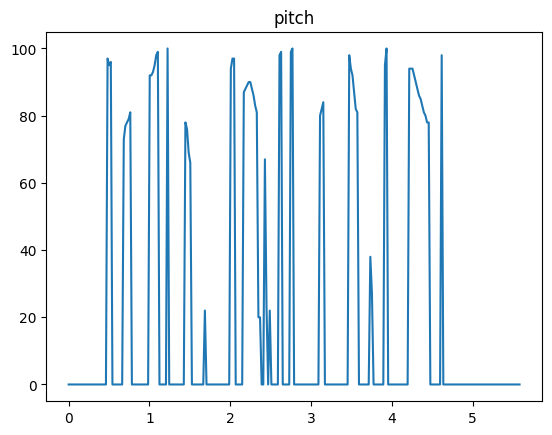

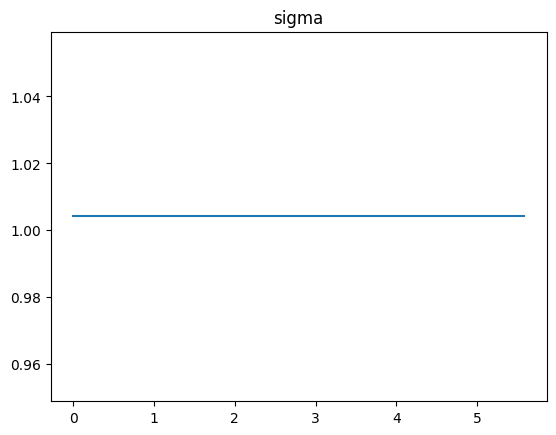

In [134]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
#animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
#display(HTML(animation.to_jshtml()))
plt.close()